In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [59]:
from graphviz import Digraph

# Helper function che serve per ottenere tutti gli edge e i node presenti nel graph partendo dal nodo di root
def trace(root):
    
    # inizializza i set vuoti
    nodes, edges = set(), set()
    
    # Funzione ricorsiva che, dato un nodo, ne estre i children e li aggiunge ai set di Edge e Node
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    # Chiamata iniziale alla funzione ricorsiva
    build(root)
    return nodes, edges

# Funzione che richiama l'API di Graphviz per disegnare il grafo con i nodi e gli edge che compongono la funzione
#
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    
    # Chiamo Helper Function per estrarre gli edge e i node
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
#        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
#        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Per automatizzare il processo di backprop, è possibile prevedere il calcolo dello step di backward all'interno del rispettivo nodo (nel Value object).

Sappiamo come implementare il gradient delle operazione di "+" e "*" e quindi possiamo implementare i rispettivi metodi.
Nel costruttore andiamo a prevedere una variabile _backwar che contiene una funzione che sa come applicare la chain rule per ciascun nodo

In [60]:
class Value:
    
    # Costruttore
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        self._backward = lambda: None   # Funzione che non fa nulla
        self._prev = set(_children) 
        self._op = _op
        self.label = label
        
    # Metodo utilizzato da Python per la visualizzazione dell'oggetto. Consente di impostare un visualizzazione user friendly
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Definisce l'operatore per la somma (+). Quando trova l'operatore +, Python chiama questo metodo
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 termini rispetto all'output.
        # Dal momento che la local derivative per una somma è = 1, moltiplico 1 * la derivata del risultato della somma
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    # Definisce l'operatore per la prodottp (*). Quando trova l'operatore *, Python chiama questo metodo
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 fattori del prodotto
        # rispetto all'output.
        # Dal momento che la local derivative per un prodotto è = al valore dell'altro fattore,
        # moltiplico l'altro fattore * la derivata del prodotto
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata della funzione tanh 
        # rispetto all'output.
        # Dal momento che la local derivative per tanh è = (1 - x**2), applicando la chain rule
        # moltiplico questa local derivative* la derivata del prodotto
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    

Reinizializiamo il NN composto da un solo neurone con 2 input ed eseguiamo il forward pass

In [61]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
#b = Value(8, label='b')
# Per facilitare i calcoli inizializzo bias ad un valore che successivamente facilita i calcoli
b = Value(6.8812735870195432, label='b')

# x1*w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b; n.label = 'n'

# In questo modo otteniamo il risultato prima dell'activation

o = n.tanh(); o.label = 'o'

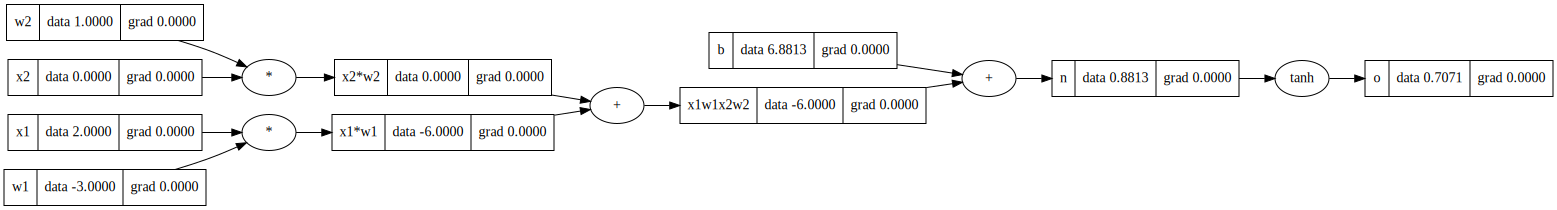

In [62]:
draw_dot(o)

Ora è possibile eseguire il backward pass (backpropagation) in automatico richiamando il metodo backward nel ordine inverso: dall'output agli inputs.

Per fare ciò è però necessario inizializzare a 1.0 il grad dell'output nei confronti di se stesso

In [63]:
o.grad = 1.0

In [64]:
o._backward()

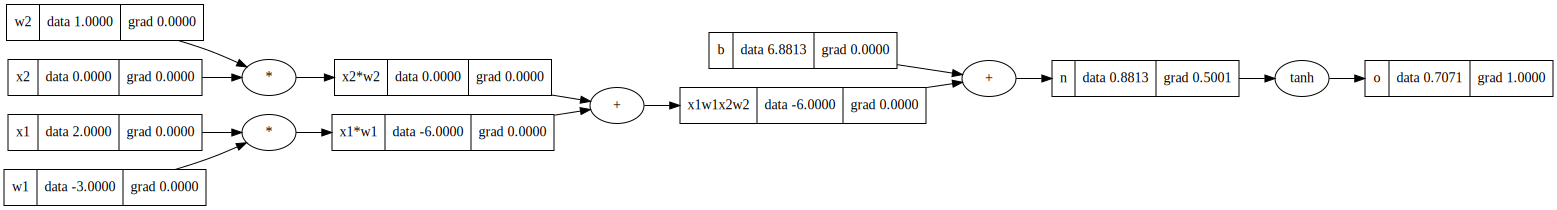

In [65]:
draw_dot(o)

Procediamo richiamando _backward() per gli altri valori intermedi

In [66]:
n._backward()

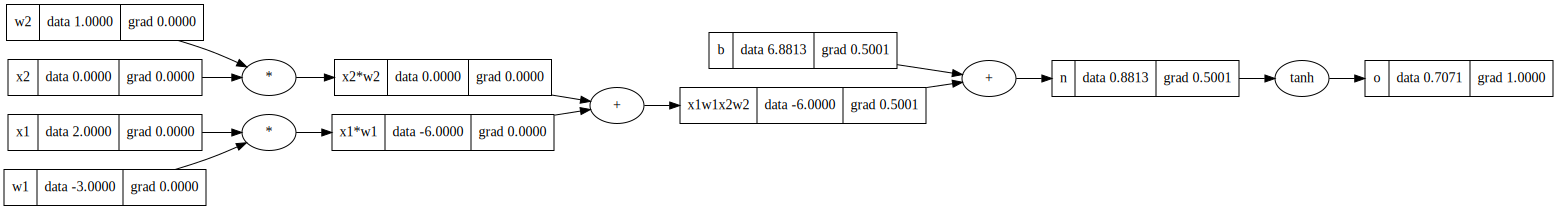

In [67]:
draw_dot(o)

In [68]:
b._backward()

In [69]:
x1w1x2w2._backward()

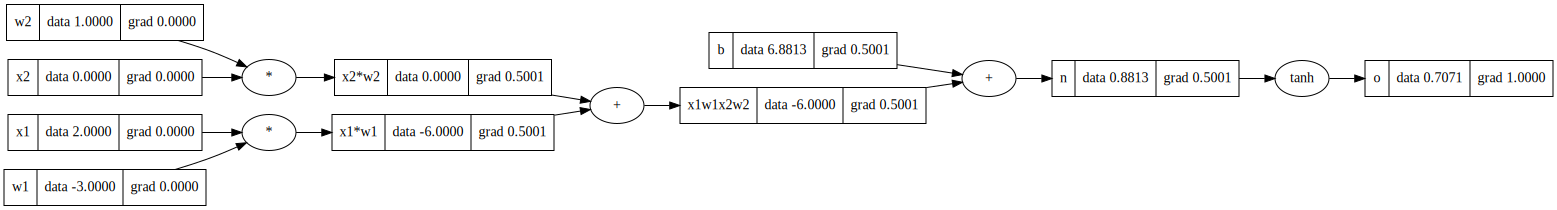

In [70]:
draw_dot(o)

In [71]:
x1w1._backward()
x2w2._backward()

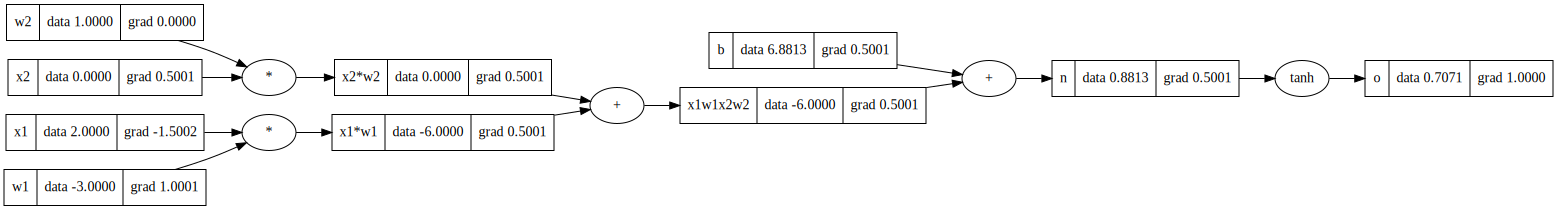

In [72]:
draw_dot(o)

Per poter automatizzare queste chiamate a _backward in modo sequenziale dal nodo di output al nodo di input è necessario utilizzare il topological sort (grafico in cui tutti gli edge vanno da sinista a destra).

Di seguito il codice per costruire un topological graph

In [73]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        
        # Ogni nodo viene aggiunto alla lista solo dopo che sono stati aggiunti i relativi children
        for child in v._prev:
            build_topo(child)
        topo.append(v)

# Partendo dal nodo di output ("o") costruiamo il topological graph della nostra espressione
build_topo(o)
topo    

[Value(data=6.881273587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8812735870195434),
 Value(data=0.7070567776509304)]

Il nostro obiettivo è chiamare _backward() in topological order.

Per fare questo re-inizializiamo il nostro NN ed eseguiamo il forward pass

In [74]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8812735870195432, label='b')

# x1*w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b; n.label = 'n'

o = n.tanh(); o.label = 'o'

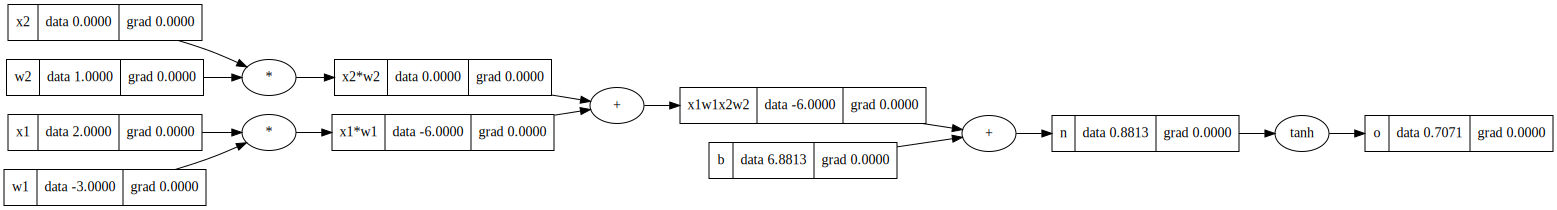

In [75]:
draw_dot(o)

Dopo aver inizializzato il grad do o a 1.0, costruiamo il topological order e richiamo backward in ordine topologico inverso.

In [76]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

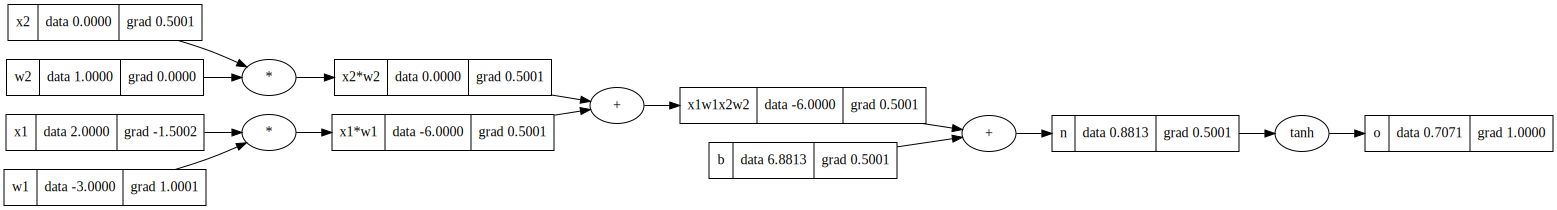

In [77]:
draw_dot(o)

Come step successivo andiamo ad inserire questo codice all'interno del nostro Value object

In [78]:
class Value:
    
    # Costruttore
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        self._backward = lambda: None   # Funzione che non fa nulla
        self._prev = set(_children) 
        self._op = _op
        self.label = label
        
    # Metodo utilizzato da Python per la visualizzazione dell'oggetto. Consente di impostare un visualizzazione user friendly
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Definisce l'operatore per la somma (+). Quando trova l'operatore +, Python chiama questo metodo
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 termini rispetto all'output.
        # Dal momento che la local derivative per una somma è = 1, moltiplico 1 * la derivata del risultato della somma
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    # Definisce l'operatore per la prodottp (*). Quando trova l'operatore *, Python chiama questo metodo
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 fattori del prodotto
        # rispetto all'output.
        # Dal momento che la local derivative per un prodotto è = al valore dell'altro fattore,
        # moltiplico l'altro fattore * la derivata del prodotto
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata della funzione tanh 
        # rispetto all'output.
        # Dal momento che la local derivative per tanh è = (1 - x**2), applicando la chain rule
        # moltiplico questa local derivative* la derivata del prodotto
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

Ora reinizializiamo e rifacciamo il farward pass

In [79]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8812735870195432, label='b')

# x1*w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b; n.label = 'n'

o = n.tanh(); o.label = 'o'

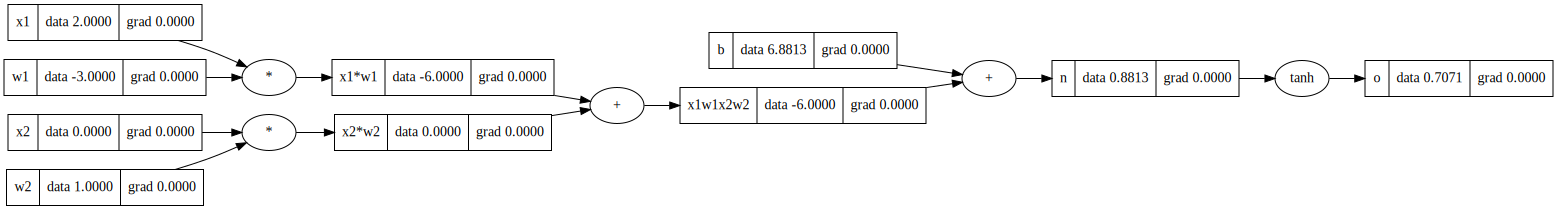

In [80]:
draw_dot(o)

Ed eseguiamo backprop

In [81]:
o.backward()

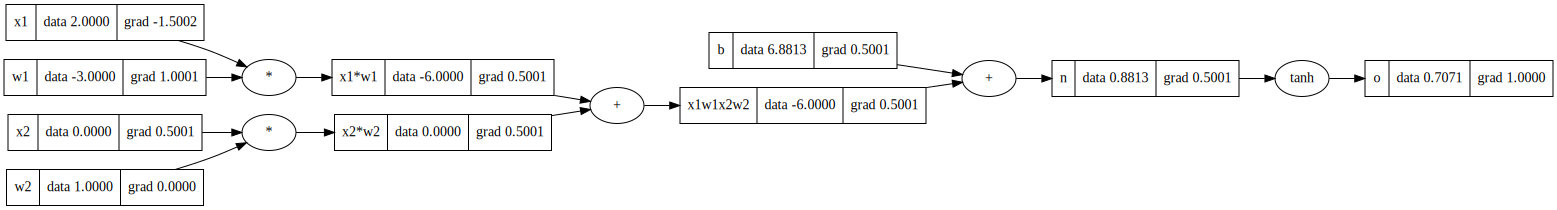

In [82]:
draw_dot(o)

E' stato necessario correggere un bug nel codice precedente nel calcolo del gradient. 
L'errore si verificava nel caso una variabile venisse utilizzata più volte in quanto il valore del gradient rispetto a quella variabile veniva sovrascritto.
La correzione è consistita nel sostituire l'assegnazione con += in modo che i gradient si accumulino

Ad esempio per la somma:

 def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        # Definisco una funzione che applica la chain rule per calcolare la derivata dei 2 termini rispetto all'output.
        # Dal momento che la local derivative per una somma è = 1, moltiplico 1 * la derivata del risultato della somma
        def _backward():
            self.grad += 1.0 * out.grad   # invece di "="
            other.grad += 1.0 * out.grad   # invece di "="
        out._backward = _backward
        return out
